## Deep Learning Case Study- Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

#### Importing required libraries

In [53]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2

We set the random seed so that the results don't vary drastically.

In [54]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [55]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10 #batch size

In [56]:
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15

In [57]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (rows,cols))
    return resized_image

In [58]:
#using percentile to deal with outliers in the data.
def normalize_image(img):
    #using percentile for normalization for images, as min-max is giving better results.
    # normalized_image= img - np.percentile(img,15)/ np.percentile(img,85) - np.percentile(img,15) 
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [59]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image=crop_resize_img(image)
                    
                    
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])#normalise and feed in the image
                    
                    x =resized_image.shape[0]
                    y =resized_image.shape[1]
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [60]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 #number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 1) CNN+ RNN

In [61]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

nb_featuremap = [8,16,32,64]
nb_dense = [256,128,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [62]:
from keras.optimizers import Adam

optimiser = Adam(0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, 15, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 15, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_47 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 15, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 15, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 7, 7, 64)      0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [63]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: Batch size= 10 and Epochs=30

In [66]:
#batch size= 10
# No. of eopochs= 30
model1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size =Epoch 1/30
 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


67/67 [==============================] - 45s 668ms/step - loss: 1.3164 - categorical_accuracy: 0.4328 - val_loss: 1.7278 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-1.31641-0.43284-1.72776-0.36000.h5
Epoch 2/30
67/67 [==============================] - 12s 184ms/step - loss: 1.2980 - categorical_accuracy: 0.4925 - val_loss: 3.0448 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-1.29796-0.49254-3.04478-0.22000.h5
Epoch 3/30
67/67 [==============================] - 15s 224ms/step - loss: 1.3402 - categorical_accuracy: 0.4577 - val_loss: 1.5555 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-1.34023-0.45771-1.55549-0.41000.h5
Epoch 4/30
67/67 [==============================] - 15s 225ms/step - loss: 1.2461 - categorical_accuracy: 0.4876 - val_loss: 1.5444 - val_categorical_accuracy: 0.4600




Epoch 00029: saving model to model_init_2020-11-0814_32_36.867914/model-00029-0.33865-0.88060-1.03137-0.64000.h5
Epoch 30/30
67/67 [==============================] - 16s 237ms/step - loss: 0.2232 - categorical_accuracy: 0.9453 - val_loss: 1.0318 - val_categorical_accuracy: 0.6400

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.22318-0.94527-1.03183-0.64000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


### *Max validation accuracy of 66%*



## Model 2 :Batch size= 20 and Epochs=30

In [67]:
batch_size = 20
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


34/34 [==============================] - 8s 241ms/step - loss: 0.3138 - categorical_accuracy: 0.8922 - val_loss: 1.2685 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-0.31382-0.89216-1.26855-0.62000.h5
Epoch 2/30
34/34 [==============================] - 8s 238ms/step - loss: 0.2679 - categorical_accuracy: 0.9412 - val_loss: 1.0081 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-0.26790-0.94118-1.00812-0.58000.h5
Epoch 3/30
34/34 [==============================] - 7s 217ms/step - loss: 0.2845 - categorical_accuracy: 0.9118 - val_loss: 1.1433 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-0.28449-0.91176-1.14334-0.60000.h5
Epoch 4/30
34/34 [==============================] - 8s 227ms/step - loss: 0.2631 - categorical_accuracy: 0.9118 - val_loss: 1.0603 - val_categorical_accuracy: 0.6800

Epoc

34/34 [==============================] - 8s 223ms/step - loss: 0.2182 - categorical_accuracy: 0.9608 - val_loss: 1.0413 - val_categorical_accuracy: 0.6600

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.21817-0.96078-1.04133-0.66000.h5


### *Max validation accuracy of 76%*

## Model 3 :Batch size= 30 and Epochs=30

In [68]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 6s 260ms/step - loss: 0.2190 - categorical_accuracy: 0.9420 - val_loss: 1.1095 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-0.21898-0.94203-1.10945-0.70000.h5
Epoch 2/30
23/23 [==============================] - 6s 255ms/step - loss: 0.3754 - categorical_accuracy: 0.8841 - val_loss: 0.9137 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-0.37538-0.88406-0.91369-0.65000.h5
Epoch 3/30
23/23 [==============================] - 6s 276ms/step - loss: 0.2545 - categorical_accuracy: 0.9275 - val_loss: 1.2849 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-0.25452-0.92754-1.28492-0.60000.h5
Epoch 4/30
23/23 [==============================] - 5s 220ms/step - loss: 0.1881 - categorical_accuracy: 0.9420 - val_loss: 1.1649 - val_categorical_accuracy: 0.6000

Epoc

23/23 [==============================] - 5s 217ms/step - loss: 0.2194 - categorical_accuracy: 0.9565 - val_loss: 0.7312 - val_categorical_accuracy: 0.7500

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.21937-0.95652-0.73124-0.75000.h5


### *Max validation accuracy of 75%*

## Model 4 :Batch size= 50 and Epochs=50

In [69]:
batch_size = 50
num_epochs = 50

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


14/14 [==============================] - 4s 253ms/step - loss: 0.3197 - categorical_accuracy: 0.8810 - val_loss: 1.1877 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-0.31970-0.88095-1.18775-0.60000.h5
Epoch 2/50
14/14 [==============================] - 3s 243ms/step - loss: 0.2011 - categorical_accuracy: 0.9762 - val_loss: 0.6129 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-0.20112-0.97619-0.61286-0.75000.h5
Epoch 3/50
14/14 [==============================] - 4s 258ms/step - loss: 0.2553 - categorical_accuracy: 0.9286 - val_loss: 1.0557 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-0.25529-0.92857-1.05566-0.60000.h5
Epoch 4/50
14/14 [==============================] - 4s 267ms/step - loss: 0.2328 - categorical_accuracy: 0.9524 - val_loss: 0.9634 - val_categorical_accuracy: 0.7000

Epoc

14/14 [==============================] - 3s 218ms/step - loss: 0.1543 - categorical_accuracy: 1.0000 - val_loss: 1.0638 - val_categorical_accuracy: 0.6000

Epoch 00029: saving model to model_init_2020-11-0814_32_36.867914/model-00029-0.15433-1.00000-1.06378-0.60000.h5
Epoch 30/50
14/14 [==============================] - 3s 197ms/step - loss: 0.3268 - categorical_accuracy: 0.9286 - val_loss: 1.0535 - val_categorical_accuracy: 0.6500

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.32679-0.92857-1.05345-0.65000.h5
Epoch 31/50
14/14 [==============================] - 3s 194ms/step - loss: 0.2006 - categorical_accuracy: 0.9286 - val_loss: 1.0025 - val_categorical_accuracy: 0.6500

Epoch 00031: saving model to model_init_2020-11-0814_32_36.867914/model-00031-0.20060-0.92857-1.00253-0.65000.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000195414814e-27.
Epoch 32/50
14/14 [==============================] - 3s 241ms/step - loss: 0.2812 - cat

### *Max validation accuracy of 85%*

### Model 5 :Batch size= 90 and Epochs=30

In [70]:
batch_size = 90
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


8/8 [==============================] - 2s 257ms/step - loss: 0.2429 - categorical_accuracy: 0.8750 - val_loss: 1.1899 - val_categorical_accuracy: 0.6500

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-0.24291-0.87500-1.18987-0.65000.h5
Epoch 2/30
8/8 [==============================] - 2s 273ms/step - loss: 0.2392 - categorical_accuracy: 0.8750 - val_loss: 0.6316 - val_categorical_accuracy: 0.7500

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-0.23918-0.87500-0.63161-0.75000.h5
Epoch 3/30
8/8 [==============================] - 2s 260ms/step - loss: 0.1682 - categorical_accuracy: 0.9167 - val_loss: 1.4567 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-0.16823-0.91667-1.45674-0.50000.h5
Epoch 4/30
8/8 [==============================] - 2s 255ms/step - loss: 0.2277 - categorical_accuracy: 0.9583 - val_loss: 1.3056 - val_categorical_accuracy: 0.4500

Epoch 00004:


Epoch 00029: saving model to model_init_2020-11-0814_32_36.867914/model-00029-0.41744-0.83333-1.24588-0.60000.h5
Epoch 30/30
8/8 [==============================] - 2s 265ms/step - loss: 0.2313 - categorical_accuracy: 0.9167 - val_loss: 1.0592 - val_categorical_accuracy: 0.5500

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.23126-0.91667-1.05923-0.55000.h5


### *Max validation accuracy of 80%*

### Model 6:  Adding more features maps and Layers

In [71]:
nb_featuremap = [8,16,32,64,128]
nb_dense = [256,128,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
optimiser = Adam(0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_54 (TimeDis (None, 15, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 7, 7, 64)      0         
__________

In [72]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 8s 365ms/step - loss: 1.6794 - categorical_accuracy: 0.2464 - val_loss: 1.7689 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-1.67944-0.24638-1.76894-0.25000.h5
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 1.4914 - categorical_accuracy: 0.2754 - val_loss: 1.7558 - val_categorical_accuracy: 0.4250

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-1.49138-0.27536-1.75576-0.42500.h5
Epoch 3/30
23/23 [==============================] - 5s 216ms/step - loss: 1.5264 - categorical_accuracy: 0.3623 - val_loss: 1.9873 - val_categorical_accuracy: 0.2250

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-1.52637-0.36232-1.98731-0.22500.h5
Epoch 4/30
23/23 [==============================] - 5s 217ms/step - loss: 1.5069 - categorical_accuracy: 0.2754 - val_loss: 1.8777 - val_categorical_accuracy: 0.1750

Epoc

23/23 [==============================] - 5s 220ms/step - loss: 1.2156 - categorical_accuracy: 0.5217 - val_loss: 1.1400 - val_categorical_accuracy: 0.5250

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-1.21563-0.52174-1.14003-0.52500.h5


### Validation accuracy is 62%

### Model 7 : Adding batch normalisation after every layer

In [73]:
nb_featuremap = [8,16,32,64,128]
nb_dense = [64]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))


## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
optimiser = Adam(0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 15, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_66 (TimeDis (None, 15, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_67 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_68 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_70 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_71 (TimeDis (None, 15, 15, 15, 32)    0         
__________

In [74]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 9s 372ms/step - loss: 1.7801 - categorical_accuracy: 0.2029 - val_loss: 1.5544 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-1.78012-0.20290-1.55438-0.35000.h5
Epoch 2/30
23/23 [==============================] - 3s 120ms/step - loss: 1.4669 - categorical_accuracy: 0.3768 - val_loss: 1.4964 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-1.46694-0.37681-1.49636-0.37500.h5
Epoch 3/30
23/23 [==============================] - 5s 225ms/step - loss: 1.4641 - categorical_accuracy: 0.3043 - val_loss: 1.6222 - val_categorical_accuracy: 0.4250

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-1.46406-0.30435-1.62215-0.42500.h5
Epoch 4/30
23/23 [==============================] - 6s 246ms/step - loss: 1.3892 - categorical_accuracy: 0.4058 - val_loss: 1.4839 - val_categorical_accuracy: 0.3750

Epoc

23/23 [==============================] - 5s 227ms/step - loss: 0.7228 - categorical_accuracy: 0.7681 - val_loss: 1.2171 - val_categorical_accuracy: 0.4250

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.72282-0.76812-1.21712-0.42500.h5


### Max validation accuracy is 65%

## CONV- 3D Model

### Model 8- Conv3D

In [75]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model3d = Sequential()
model3d.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d.add(Activation('relu'))
model3d.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(BatchNormalization())
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Flatten())
model3d.add(Dense(nb_dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model3d.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.001)
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 15, 120, 120, 8)   3008      
_________________________________________________________________
activation_16 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 15, 120, 120, 16)  3472      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 7, 60, 60, 32)     4640      
_________________________________________________________________
activation_18 (Activation)   (None, 7, 60, 60, 32)     0         
__________

In [77]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 6s 261ms/step - loss: 0.8849 - categorical_accuracy: 0.7101 - val_loss: 1.0179 - val_categorical_accuracy: 0.5750

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-0.88491-0.71014-1.01789-0.57500.h5
Epoch 2/30
23/23 [==============================] - 5s 230ms/step - loss: 0.7676 - categorical_accuracy: 0.7101 - val_loss: 1.1074 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-0.76761-0.71014-1.10736-0.50000.h5
Epoch 3/30
23/23 [==============================] - 6s 243ms/step - loss: 0.5915 - categorical_accuracy: 0.7681 - val_loss: 1.1110 - val_categorical_accuracy: 0.4750

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-0.59145-0.76812-1.11096-0.47500.h5
Epoch 4/30
23/23 [==============================] - 5s 211ms/step - loss: 0.7391 - categorical_accuracy: 0.6957 - val_loss: 1.0937 - val_categorical_accuracy: 0.6500

Epoc

23/23 [==============================] - 5s 206ms/step - loss: 0.7694 - categorical_accuracy: 0.7101 - val_loss: 1.1176 - val_categorical_accuracy: 0.5250

Epoch 00029: saving model to model_init_2020-11-0814_32_36.867914/model-00029-0.76936-0.71014-1.11756-0.52500.h5
Epoch 30/30
23/23 [==============================] - 6s 239ms/step - loss: 0.8095 - categorical_accuracy: 0.7101 - val_loss: 1.2282 - val_categorical_accuracy: 0.4500

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-0.80949-0.71014-1.22818-0.45000.h5


### Validation accuracy is 75%

### Model 9- Adding more layers and batch normalisation

In [78]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5

# Input
input_shape=(frames,rows,cols,channel)

model3d = Sequential()
model3d.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())

model3d.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(BatchNormalization())
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Flatten())
model3d.add(Dense(nb_dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model3d.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.001)
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 15, 120, 120, 8)   3008      
_________________________________________________________________
activation_19 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 15, 120, 120, 16)  3472      
_________________________________________________________________
activation_20 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 7, 60, 60, 32)     4640      
_________________________________________________________________
activation_21 (Activation)   (None, 7, 60, 60, 32)     0         
__________

In [79]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 15s 651ms/step - loss: 9.0697 - categorical_accuracy: 0.5072 - val_loss: 6.1874 - val_categorical_accuracy: 0.5250

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-9.06974-0.50725-6.18737-0.52500.h5
Epoch 2/30
23/23 [==============================] - 3s 149ms/step - loss: 9.6721 - categorical_accuracy: 0.6522 - val_loss: 8.5436 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-9.67214-0.65217-8.54363-0.60000.h5
Epoch 3/30
23/23 [==============================] - 5s 233ms/step - loss: 8.6330 - categorical_accuracy: 0.5652 - val_loss: 8.5420 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-8.63297-0.56522-8.54198-0.50000.h5
Epoch 4/30
23/23 [==============================] - 5s 238ms/step - loss: 8.6084 - categorical_accuracy: 0.5942 - val_loss: 7.7047 - val_categorical_accuracy: 0.7000

Epo

23/23 [==============================] - 6s 244ms/step - loss: 8.5789 - categorical_accuracy: 0.5507 - val_loss: 8.0875 - val_categorical_accuracy: 0.5750

Epoch 00029: saving model to model_init_2020-11-0814_32_36.867914/model-00029-8.57885-0.55072-8.08747-0.57500.h5
Epoch 30/30
23/23 [==============================] - 6s 244ms/step - loss: 9.0629 - categorical_accuracy: 0.5362 - val_loss: 7.3473 - val_categorical_accuracy: 0.5250

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-9.06289-0.53623-7.34728-0.52500.h5


### Model 10- Reducing filter size to (2,2,2) for all layers

In [80]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5

# Input
input_shape=(frames,rows,cols,channel)

model3d = Sequential()
model3d.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(2,2,2),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())

model3d.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(2,2,2),
                 padding='same',name="conv2"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model3d.add(Activation('relu'))
model.add(BatchNormalization())
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(BatchNormalization())
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Flatten())
model3d.add(Dense(nb_dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model3d.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.001)
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 15, 120, 120, 8)   200       
_________________________________________________________________
activation_22 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 15, 120, 120, 16)  1040      
_________________________________________________________________
activation_23 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 7, 60, 60, 32)     4640      
_________________________________________________________________
activation_24 (Activation)   (None, 7, 60, 60, 32)     0         
__________

In [81]:
batch_size = 30
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


23/23 [==============================] - 17s 758ms/step - loss: 8.1744 - categorical_accuracy: 0.5942 - val_loss: 7.6903 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-11-0814_32_36.867914/model-00001-8.17436-0.59420-7.69031-0.55000.h5
Epoch 2/30
23/23 [==============================] - 3s 148ms/step - loss: 8.3459 - categorical_accuracy: 0.6232 - val_loss: 6.8638 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-11-0814_32_36.867914/model-00002-8.34588-0.62319-6.86379-0.55000.h5
Epoch 3/30
23/23 [==============================] - 5s 229ms/step - loss: 9.0199 - categorical_accuracy: 0.5362 - val_loss: 7.2802 - val_categorical_accuracy: 0.6250

Epoch 00003: saving model to model_init_2020-11-0814_32_36.867914/model-00003-9.01989-0.53623-7.28024-0.62500.h5
Epoch 4/30
23/23 [==============================] - 5s 238ms/step - loss: 7.4933 - categorical_accuracy: 0.4783 - val_loss: 10.5910 - val_categorical_accuracy: 0.5250

Ep

23/23 [==============================] - 6s 241ms/step - loss: 7.6887 - categorical_accuracy: 0.5362 - val_loss: 7.7134 - val_categorical_accuracy: 0.4750

Epoch 00030: saving model to model_init_2020-11-0814_32_36.867914/model-00030-7.68869-0.53623-7.71341-0.47500.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-24.


### Models summary

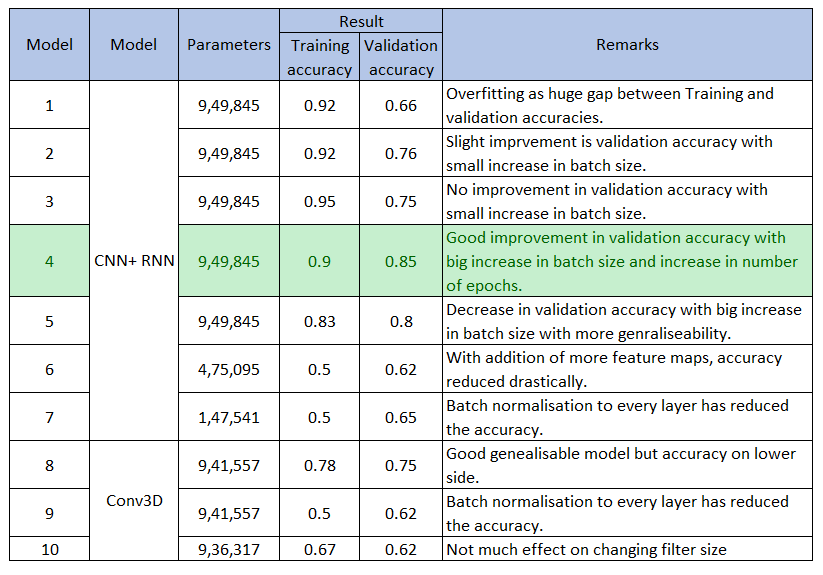

## After doing all the experiments, we finalized Model 4 - CNN+GRU, which performed well.
__Reason:__

__- (Training Accuracy : 90%, Validation Accuracy : 85%)__

__- Number of Parameters(9,49,845)__

__The best weights of CNN-LSTM: model-00016-0.27619-0.90476-0.40844-0.85000.h5 (11.5 MB).__

# Loading the final model

In [86]:
import time
from keras.models import load_model
model = load_model('model-00016-0.27619-0.90476-0.40844-0.85000.h5')